# 📊 Analisi delle Metriche per la Predizione della Mobilità Umana

Questo notebook è stato progettato per analizzare le performance del framework **LLM-Mob** nella predizione della mobilità umana.  
Esso calcola automaticamente e visualizza le principali metriche di valutazione per ogni configurazione sperimentale prodotta (top@1, top@10, con/ senza informazioni temporali) sui dataset **Geolife** e **Foursquare**.

## ✅ Funzionalità principali:
- Calcolo di **Accuracy@10**, **F1 Score (macro)**, **nDCG@10**
- Parsing robusto delle predizioni da CSV salvati
- Rimozione automatica dei dati non validi (es. orari al posto degli ID)
- Visualizzazione grafica dei risultati con valori etichettati
- Supporto multi-configurazione e multi-dataset

Assicurati che la struttura delle cartelle `output/.../*.csv` sia presente prima dell'esecuzione.


In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import logging
from sklearn.metrics import f1_score
from pathlib import Path
import numpy as np

# Logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("multi_metrics")

# 📁 Percorsi da analizzare
configs = [
    "output/geolife/top1",
    "FILE ORIGINALI/results/geolife/top1",
    "output/geolife/top10",
    "FILE ORIGINALI/results/geolife/top10",
    "output/geolife/top10_wot",
    "FILE ORIGINALI/results/geolife/top10_wot",
    "output/fsq/top1",
    "FILE ORIGINALI/results/fsq/top1",
    "output/fsq/top10",
    "FILE ORIGINALI/results/fsq/top10",
    "output/fsq/top10_wot",
    "FILE ORIGINALI/results/fsq/top10_wot",
]


In [23]:
def safe_parse_prediction(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif isinstance(x, list):
            return x
        else:
            return []
    except Exception as e:
        logger.warning(f"⚠️ Parsing fallito per predizione: {x} con errore: {e}")
        return []

def safe_cast_gt(val):
    try:
        val = str(val).strip()
        if ':' in val:
            raise ValueError("Valore orario trovato")
        return int(val)
    except Exception as e:
        logger.warning(f"⚠️ Valore ignorato in ground_truth: {val} ({e})")
        return None

def safe_cast_pred(val):
    try:
        if isinstance(val, str) and ':' in val:
            raise ValueError("Valore orario trovato nella predizione")
        return int(val)
    except Exception as e:
        logger.warning(f"⚠️ Predizione ignorata (non valida): {val} ({e})")
        return -1


In [24]:
def ndcg_at_k(predictions, ground_truths, k=10):
    dcg = 0.0
    for idx, pred in enumerate(predictions[:k]):
        if pred == ground_truths:
            dcg = 1 / np.log2(idx + 2)
            break
    idcg = 1.0
    return dcg / idcg


In [ ]:
def analyze_config(path):
    logger.info(f"📂 Analisi cartella: {path}")
    
    if not os.path.exists(path):
        logger.warning(f"🚫 Cartella non trovata: {path}\n\n")
        return
    
    file_list = sorted([f for f in os.listdir(path) if f.endswith(".csv")])
    df = pd.DataFrame()
    
    for file in file_list:
        file_path = os.path.join(path, file)
        try:
            temp_df = pd.read_csv(file_path)
            df = pd.concat([df, temp_df], ignore_index=True)
        except Exception as e:
            logger.warning(f"❌ Errore lettura {file_path}: {e}")
    
    df['ground_truth'] = df['ground_truth'].apply(safe_cast_gt)
    df = df.dropna(subset=['ground_truth'])

    total_before = len(df)
    df['prediction'] = df['prediction'].apply(safe_parse_prediction)

    df['hit@10'] = df.apply(
        lambda row: row['ground_truth'] in row['prediction'] if isinstance(row['prediction'], list) else False,
        axis=1
    )
    acc_at_10 = df['hit@10'].mean()

    df['ndcg@10'] = df.apply(
        lambda row: ndcg_at_k(row['prediction'], row['ground_truth'], k=10) if isinstance(row['prediction'], list) else 0,
        axis=1
    )
    ndcg_score = df['ndcg@10'].mean()

    # Costruzione majority_preds con parsing sicuro
    df['top1'] = df['prediction'].apply(lambda row: safe_cast_pred(row[0]) if isinstance(row, list) and row else -1)
    try:
        df['ground_truth'] = df['ground_truth'].astype(int)
        f1 = f1_score(df['ground_truth'], df['top1'], average='macro')
    except Exception as e:
        logger.warning(f"⚠️ Errore F1 Score: {e}")
        f1 = 0.0

    # 📊 Plotting
    plt.figure(figsize=(7, 5))
    metric_values = [acc_at_10, f1, ndcg_score]
    metric_names = ['Acc@10', 'F1', 'nDCG@10']
    bars = sns.barplot(x=metric_names, y=metric_values)

    for bar, val in zip(bars.patches, metric_values):
        bars.annotate(f"{val:.3f}", (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                      ha='center', va='bottom', fontsize=10, color='black')

    plt.title(f"Metriche - {path}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.show()

    print(f"📊 Righe valide usate: {len(df)} / {total_before}")
    print(f"✅ Acc@10: {round(acc_at_10, 4)}")
    print(f"✅ F1 Score: {round(f1, 4)}")
    print(f"✅ nDCG@10: {round(ndcg_score, 4)}")
    return df


INFO:multi_metrics:📂 Analisi cartella: output/geolife/top1
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/geolife/top1
INFO:multi_metrics:📂 Analisi cartella: output/geolife/top10
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/geolife/top10
INFO:multi_metrics:📂 Analisi cartella: output/geolife/top10_wot
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/geolife/top10_wot
INFO:multi_metrics:📂 Analisi cartella: output/fsq/top1
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/fsq/top1
INFO:multi_metrics:📂 Analisi cartella: output/fsq/top10
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/fsq/top10


INFO:multi_metrics:📂 Analisi cartella: output/fsq/top10_wot
INFO:multi_metrics:📂 Analisi cartella: FILE ORIGINALI/results/fsq/top10_wot


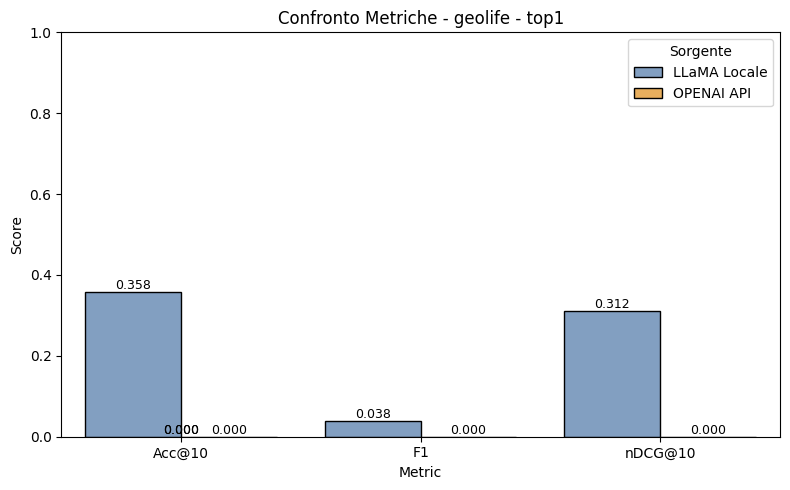

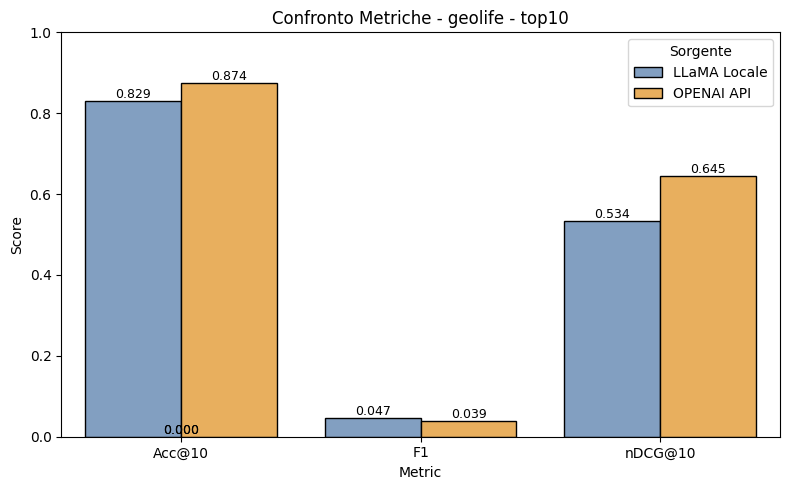

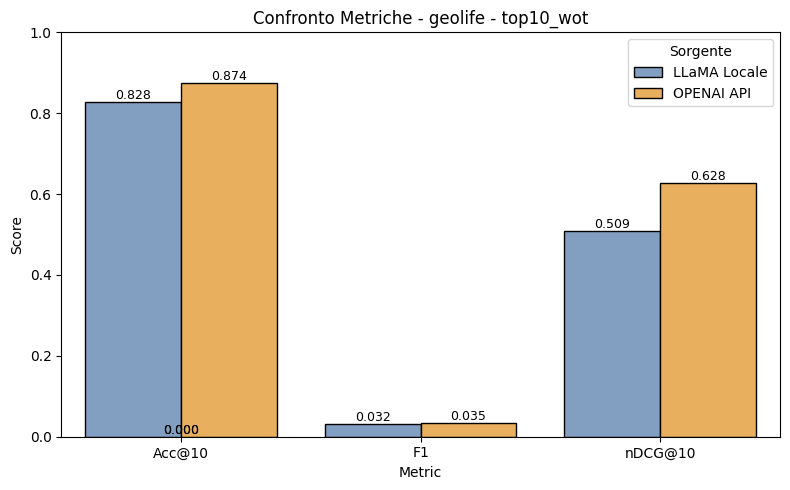

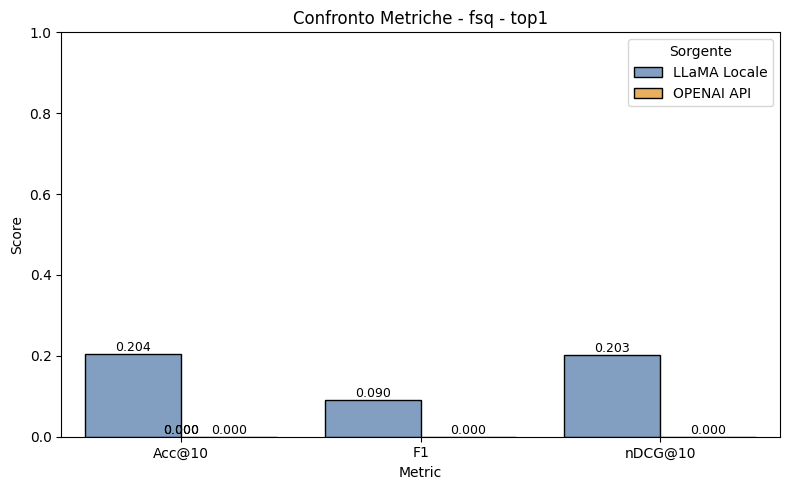

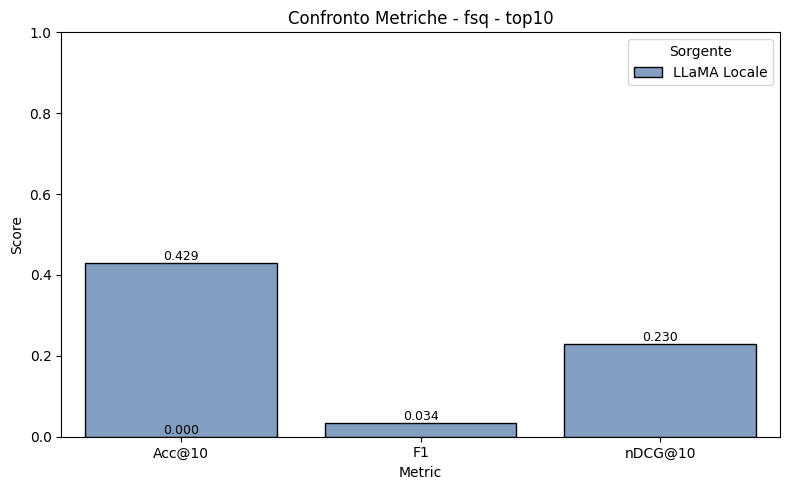

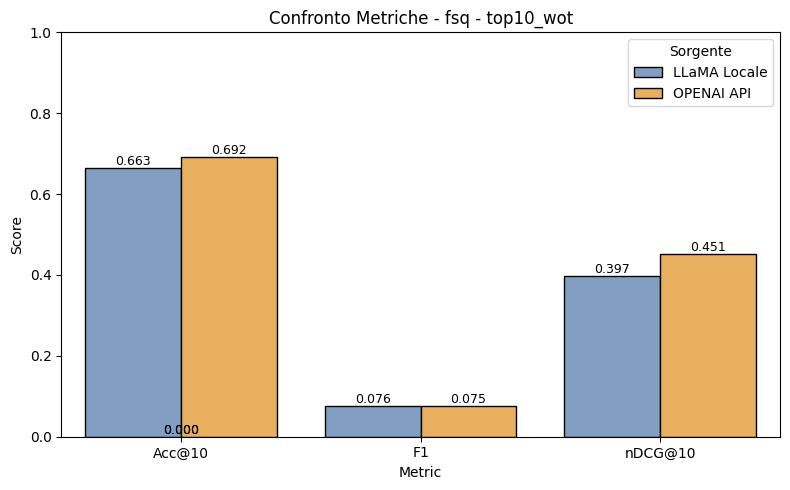

In [26]:

all_results = []

def analyze_and_collect(path):
    logger.info(f"📂 Analisi cartella: {path}")
    
    if not os.path.exists(path):
        logger.warning(f"🚫 Cartella non trovata: {path}\n\n")
        return
    
    file_list = sorted([f for f in os.listdir(path) if f.endswith(".csv")])
    df = pd.DataFrame()
    
    for file in file_list:
        file_path = os.path.join(path, file)
        try:
            temp_df = pd.read_csv(file_path)
            df = pd.concat([df, temp_df], ignore_index=True)
        except Exception as e:
            logger.warning(f"❌ Errore lettura {file_path}: {e}")
    
    df['ground_truth'] = df['ground_truth'].apply(safe_cast_gt)
    df = df.dropna(subset=['ground_truth'])

    total_before = len(df)
    df['prediction'] = df['prediction'].apply(safe_parse_prediction)

    df['hit@10'] = df.apply(
        lambda row: row['ground_truth'] in row['prediction'] if isinstance(row['prediction'], list) else False,
        axis=1
    )
    acc_at_10 = df['hit@10'].mean()

    df['ndcg@10'] = df.apply(
        lambda row: ndcg_at_k(row['prediction'], row['ground_truth'], k=10) if isinstance(row['prediction'], list) else 0,
        axis=1
    )
    ndcg_score = df['ndcg@10'].mean()

    df['top1'] = df['prediction'].apply(lambda row: safe_cast_pred(row[0]) if isinstance(row, list) and row else -1)
    try:
        df['ground_truth'] = df['ground_truth'].astype(int)
        f1 = f1_score(df['ground_truth'], df['top1'], average='macro')
    except Exception as e:
        logger.warning(f"⚠️ Errore F1 Score: {e}")
        f1 = 0.0

    source = "OPENAI API" if "FILE ORIGINALI" in path else "LLaMA Locale"
    dataset = "geolife" if "geolife" in path else "fsq"
    config = path.split("/")[-1]

    all_results.append({
        "dataset": dataset,
        "config": config,
        "source": source,
        "Acc@10": acc_at_10,
        "F1": f1,
        "nDCG@10": ndcg_score
    })

# 🚀 Analisi di tutte le configurazioni
for path in configs:
    analyze_and_collect(path)

# 📊 Plotting comparativo
df_all = pd.DataFrame(all_results)
palette = {"OPENAI API": "#FFB347", "LLaMA Locale": "#779ECB"}

for dataset in df_all["dataset"].unique():
    for config in df_all["config"].unique():
        df_plot = df_all[(df_all["dataset"] == dataset) & (df_all["config"] == config)]
        if df_plot.empty:
            continue
        df_plot_melted = df_plot.melt(id_vars=["source"], value_vars=["Acc@10", "F1", "nDCG@10"], 
                                      var_name="Metric", value_name="Score")
        plt.figure(figsize=(8, 5))
        bars = sns.barplot(data=df_plot_melted, x="Metric", y="Score", hue="source", palette=palette, edgecolor='black')
        plt.title(f"Confronto Metriche - {dataset} - {config}")
        plt.ylim(0, 1)
        plt.ylabel("Score")
        for bar in bars.patches:
            height = bar.get_height()
            bars.annotate(f"{height:.3f}", 
                          (bar.get_x() + bar.get_width() / 2, height),
                          ha='center', va='bottom', fontsize=9)
        plt.legend(title="Sorgente")
        plt.tight_layout()
        plt.show()
